## The Poisson's problem
The Poisson's problem is given as:
\begin{equation}
\begin{cases}
- \Delta u &= f, \quad x\in\Omega\\
       u & =0, \quad x\in\partial\Omega
\end{cases}
\end{equation}
where $\Omega=[0,1]^2$ and $f(x)=2\lambda^2 * \sin(\lambda x_1)*\sin(\lambda x_2)$ where $\lambda=4\pi$. It has explicit solution:
\begin{equation}
u(x) = \sin(\lambda x_1)*\sin(\lambda x_2).
\end{equation}

### (1) Data generating

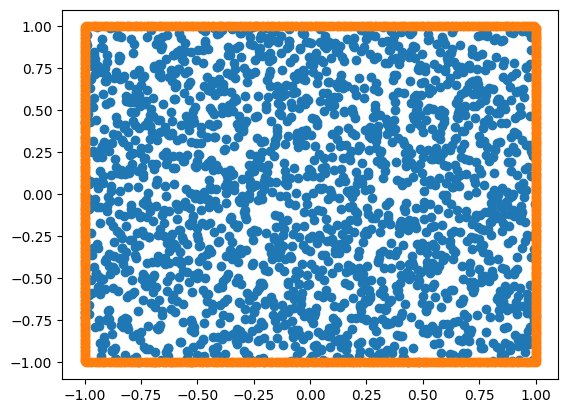

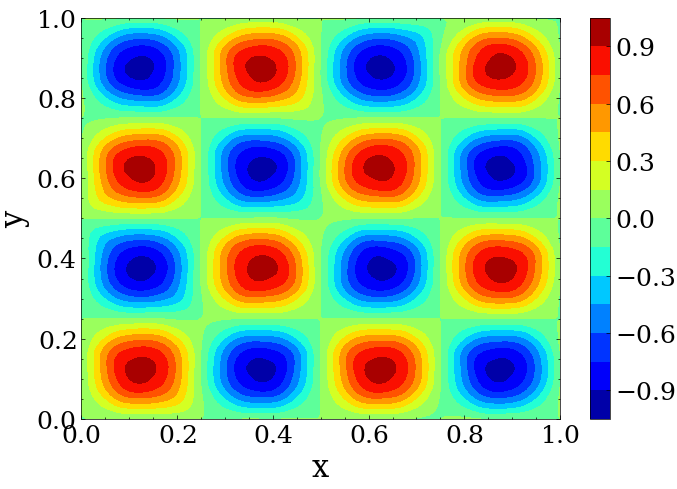

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Poisson_2d'
######################################
# Setups of the problem 
######################################
from Utils.GenPoints import Point2D
from Problems.Poisson.Poisson_2d import Problem
problem = Problem(freq=4.*np.pi)
pointGen = Point2D(x_lb=problem._lb, x_ub=problem._ub, dataType=dtype, random_seed=random_seed)
#
N_center, N_bd_each_edge = 2000, 200
xc_train, R_train = pointGen.weight_centers(n_center=N_center, R_max=1e-4, R_min=1e-4)
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
x_test = pointGen.inner_point(num_sample_or_mesh=25, method='mesh')
#########################################
plt.figure()
plt.scatter(xc_train[...,0], xc_train[...,1])
plt.scatter(x_bd_train[:,0], x_bd_train[:,1])
plt.show()
#######################################
from Utils.PlotFigure import Plot
u_test = problem._u_star(x_test)
Plot.show_2d(x_test, u_test)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, _, _ = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, 
    dataType=dtype).get_testFun()

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, grid):
        '''Define the mollifer
        '''
        x_mesh, y_mesh = grid[...,0:1], grid[...,1:2]
        u = u * torch.sin(np.pi * x_mesh)*torch.sin(np.pi * y_mesh)
        return u

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.mollifer = mollifer()
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = self.solver.model_dict['u']
        ######################## 
        self.int_grid = int_grid.to(self.solver.device)
        self.n_grid = int_grid.shape[0]
        
    def Loss_pde(self, xc=None):
        '''
        '''
        # ################################## 
        xc, R = pointGen.weight_centers(n_center=2000, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        #############################################
        nc = xc.shape[0]
        #
        x_in = (self.int_grid * R + xc).reshape(-1, 2)
        x_list = torch.split(x_in, split_size_or_sections=1, dim=1)
        x_list = [Variable(x, requires_grad=True) for x in x_list]
        x = torch.cat(x_list, dim=1)
        ###########################
        u = self.model_u(x)
        if self.mollifer is not None:
            u = self.mollifer(u, x)
        #
        du_list = self.solver.grad(u, x_list)
        Lu = self.solver.div([du for du in du_list], x_list)
        ############## The pde
        loss = self.solver.getLoss(-Lu, problem.fun_f(x))
        
        return loss * 1.

    def Loss_bd(self):
        ''' '''
        if self.mollifer is None:
            x = Variable(x_bd_train, requires_grad=True).to(self.device)
            u, u_ = self.model_u(x), problem._u_star(x)
            #
            loss = self.solver.getLoss(u, u_)
        else:
            loss = torch.tensor(0., device=self.device)
        
        return loss * 5.

    def Error(self):
        '''
        '''
        x = x_test.to(self.solver.device)
        u = u_test.to(self.solver.device)
        ####### 
        u_pred = self.model_u(x)
        if self.mollifer is not None:
            u_pred = self.mollifer(u_pred, x)
        #
        error = self.solver.getError(u_pred, u)

        return error

# #####################################
# # Define the model
# #####################################
from Solvers.PINN import PINN
#
solver = PINN.Solver(device, dtype=dtype)
model_u = solver.getModel([2, 40, 40, 40, 1], 'Tanh_Sin', netType='FCNet')

### (3) load saved model and make prediction

#### (3.1) train the model

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', lbfgs=False, max_iter=1000)
solver.train(LossClass, xc_train, batch_size_in=int(xc_train.shape[0]/100), epochs=1000, 
             epoch_show=100, **{'save_path':f'saved_models/'})
# solver.train_lbfgs(LossClass, xc, epochs=200, **{'save_path':f'saved_models/'})

 10%|███████▉                                                                       | 100/1000 [02:52<25:23,  1.69s/it]

Epoch:100 Time:172.2212, loss_in:1.376409, loss_bd:0.000000
          lr: 0.001 l2_err 0.015044989995658398


 20%|███████████████▊                                                               | 200/1000 [05:41<22:33,  1.69s/it]

Epoch:200 Time:341.3875, loss_in:1.206292, loss_bd:0.000000
          lr: 0.0005 l2_err 0.014592559076845646


 30%|███████████████████████▋                                                       | 300/1000 [08:30<19:40,  1.69s/it]

Epoch:300 Time:510.4315, loss_in:0.679779, loss_bd:0.000000
          lr: 0.0005 l2_err 0.006543600000441074


 40%|███████████████████████████████▌                                               | 400/1000 [11:19<16:56,  1.69s/it]

Epoch:400 Time:679.7157, loss_in:0.648680, loss_bd:0.000000
          lr: 0.00025 l2_err 0.008278679102659225


 50%|███████████████████████████████████████▌                                       | 500/1000 [14:09<14:07,  1.69s/it]

Epoch:500 Time:849.0972, loss_in:0.402230, loss_bd:0.000000
          lr: 0.00025 l2_err 0.003276385832577944


 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:58<11:17,  1.69s/it]

Epoch:600 Time:1018.4762, loss_in:0.375311, loss_bd:0.000000
          lr: 0.000125 l2_err 0.003683253191411495


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [19:47<08:28,  1.69s/it]

Epoch:700 Time:1187.9275, loss_in:0.301400, loss_bd:0.000000
          lr: 0.000125 l2_err 0.002720401855185628


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [22:37<05:38,  1.69s/it]

Epoch:800 Time:1357.3268, loss_in:0.286600, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0020990888588130474


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [25:26<02:49,  1.69s/it]

Epoch:900 Time:1526.6674, loss_in:0.257008, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0014414946781471372


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [28:15<00:00,  1.70s/it]

Epoch:1000 Time:1695.9446, loss_in:0.253043, loss_bd:0.000000
          lr: 3.125e-05 l2_err 0.0015623257495462894
The total training time is 1695.9672


#### (3.2) make prediction

The l2_err is tensor([0.0016])


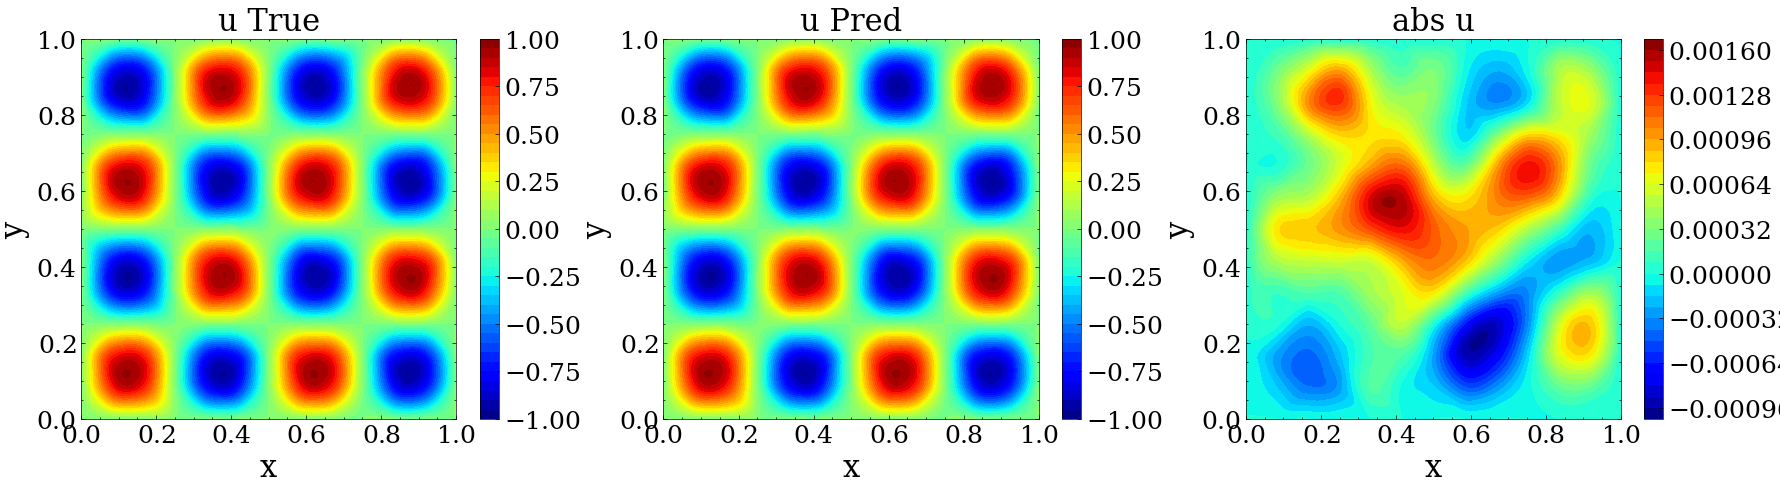

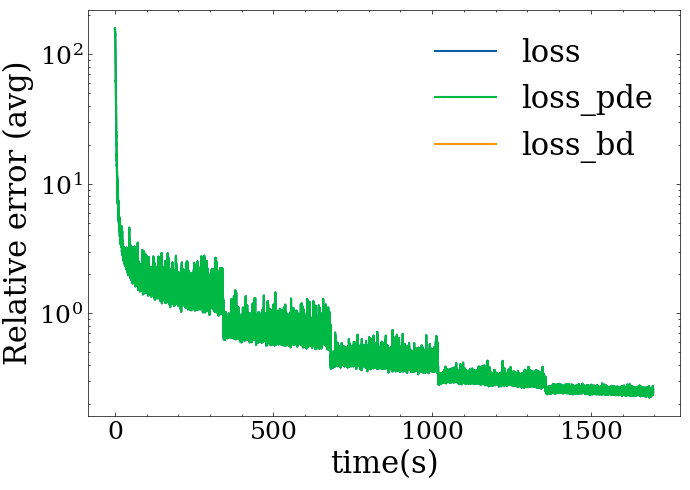

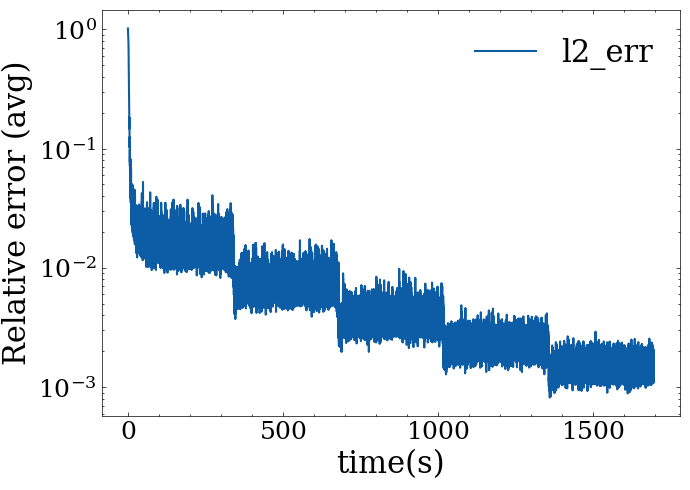

In [3]:
from torch.autograd import grad, Variable
from Utils.PlotFigure import Plot
from Solvers.PINN import PINN
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = PINN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_pinn_final')

###############################
# make prediction
###############################
x_var = Variable(x_test, requires_grad=True).to(device)
u_var = model_trained['u'](x_var)
u_var = mollifer()(u_var, x_var)
#
du_var = grad(inputs=x_var, outputs=u_var, grad_outputs=torch.ones_like(u_var), create_graph=True)[0]
ux_var, uy_var = du_var[...,0:1].detach().cpu(), du_var[...,1:2].detach().cpu()
u_var = u_var.detach().cpu()
#
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_2d_list(x_test, [u_test, u_var, u_test-u_var], ['u True', 'u Pred', 'abs u'])
##### show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_pinn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
##### show the error
Plot.show_error([loss_saved['time']], [loss_saved['error']], ['l2_err'])